In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from progressbar import ProgressBar
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as BE
from tensorflow.keras.models import Model
import os
import tensorflow as tf
from Integrated_Gradients_algorithm import *

# tf.enable_eager_execution(
#     config=None,
#     device_policy=None,
#     execution_mode=None
# )
# tf.compat.v1.disable_eager_execution()
# tf.config.run_functions_eagerly(True)
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.compat.v1.Session(config=config)     

In [2]:
# import keras
def get_loss_gradients(img_input, model, target_one_hot, from_logits=False):
    images = tf.cast(img_input, tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=from_logits)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        loss = cce(target_one_hot, preds)
#         top_class = preds[:, top_pred_idx]

    grads = tape.gradient(loss, images)
    return grads

In [3]:
def get_acc(predict_label, ground_truth=None):
    for i in predict_label[0]:
        if i[0] == ground_truth:
            return True
    return False

def softmax( f ):
    # instead: first shift the values of f so that the highest number is 0:
    s = f-np.max(f) # f becomes [-666, -333, 0]
    return np.exp(s) / np.sum(np.exp(s))  # safe to do, gives the correct answer

def get_APFD(Gini_indexs, ground_truth_label, predicted_confidence, top_set=None):
    o_i = 0
    pbar = ProgressBar()
    wrong_num = 0
    wrong_index = []
    for i in pbar(range(0, len(Gini_indexs))):
        if top_set is not None:
            if not get_acc(predict_label=decode_predictions(predicted_confidence[Gini_indexs[i]], top=top_set), 
                           ground_truth=ground_truth_label[Gini_indexs[i]]):
                o_i = o_i+i
#                 print(i, o_i)
                wrong_num = wrong_num+1
                wrong_index.append(i)
        else:
            if np.argmax(ground_truth_label[Gini_indexs[i]]) != np.argmax(predicted_confidence[Gini_indexs[i]]):
                o_i = o_i+i
                wrong_num = wrong_num+1
                wrong_index.append(i)
    APFD = 1 - o_i/(len(Gini_indexs)*wrong_num) + 1/(2*len(Gini_indexs))
    return APFD, wrong_num, wrong_index

def get_RAUC(Gini_indexs, ground_truth_label, predicted_confidence, top_set=None):
    pre_y_axis = []
    o_i = 0
    wrong_num = 0
    pbar = ProgressBar()
    for i in pbar(range(0, len(Gini_indexs))):
        if top_set is not None:
            if not get_acc(predict_label=decode_predictions(predicted_confidence[Gini_indexs[i]], top=top_set), 
                           ground_truth=ground_truth_label[Gini_indexs[i]]):  
                o_i = o_i+1
                wrong_num = wrong_num+1
                pre_y_axis.append(o_i)
            else:
                pre_y_axis.append(o_i)
        else:
            if np.argmax(ground_truth_label[Gini_indexs[i]]) != np.argmax(predicted_confidence[Gini_indexs[i]]):
                o_i = o_i+1
                wrong_num = wrong_num+1
                pre_y_axis.append(o_i)
            else:
                pre_y_axis.append(o_i)
    true_y_axis = wrong_num*(len(Gini_indexs)-wrong_num) + (wrong_num+1)*wrong_num/2
    RAUC = np.sum(pre_y_axis)/true_y_axis
#     print("RAUC: ", RAUC)
    return RAUC, len(Gini_indexs), wrong_num

In [4]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = np.reshape(X_train,[-1,28*28])
X_test = np.reshape(X_test,[-1,28*28])
Y_train = to_categorical(Y_train,10)
Y_test = to_categorical(Y_test,10)

In [5]:
# input_shape = 28*28

# model = Sequential()
# model.add(Dense(input_shape=(input_shape,), units=input_shape, activation='relu'))
# model.add(Dense(units=128, activation='relu'))
# model.add(Dense(units=32, activation='relu'))
# model.add(Dense(units=10, activation='softmax'))
# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # # model training
# # model.fit(X_train, Y_train, epochs=1, batch_size=512)

# # MODEL_PATH = "/public/liujiawei/huawei/ZHB/ADF-master/models/"
# # model.save(MODEL_PATH+"fmnist_FC4_bad.h5")

# # del model

In [6]:
MODEL_PATH = "/public/liujiawei/huawei/ZHB/ADF-master/models/"
model = load_model(MODEL_PATH+"fmnist_FC4_bad.h5")

In [7]:
loss_acc = model.evaluate(X_test, Y_test, batch_size=128)
print('accuracy', loss_acc[-1])

79/79 [==============================] - 1s 2ms/step - loss: 1.2974 - accuracy: 0.7201
accuracy 0.7200999855995178


In [14]:
img_num = 100
X_test = X_test[0:img_num]
Y_test = Y_test[0:img_num]
Gini = []
predicted_confidence = []
index1 = 0
index2 = 0
pbar = ProgressBar()
for x_tmp in pbar(X_test):
    per_tmp = model.predict(x_tmp.reshape([-1,28*28]))
    label_tmp = np.argmax(per_tmp)
    if label_tmp == np.argmax(Y_test[index1]):
        index2 = index2 +1
    index1 = index1 + 1
    Gini_tmp = 1-np.sum(per_tmp*per_tmp)
#     Gini_tmp = -np.sum(per_tmp*np.log2(per_tmp))
    Gini.append(Gini_tmp)
    predicted_confidence.append(per_tmp)
    
indexs = np.argsort(Gini)
indexs = indexs[::-1]

APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print('APFD:', APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print('RAUC:', RAUC)

100% |########################################################################|
100% |########################################################################|


APFD: 0.745625
RAUC: 0.8764792899408284


In [9]:
print('test number:', index1, '\t misclassified number:', index1-index2)

test number: 1000 	 misclassified number: 285


In [10]:
# o_i = 0
# for i in range(0, (index1)):
#     x_tmp = X_test[indexs[i]].reshape([-1,28*28])
#     y_tmp = Y_test[indexs[i]]
#     per_tmp = model.predict(x_tmp)
#     if np.argmax(y_tmp)!=np.argmax(per_tmp):
#         o_i = o_i+i
# APFD = 1-o_i/(index1*(index1-index2))+1/(2*index1)
# print(APFD)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 720,378
Trainable params: 720,378
Non-trainable params: 0
_________________________________________________________________


In [12]:
# # use one layer's activation
# get_activations = BE.function(inputs=model.inputs[0], outputs=model.layers[-3].output[:,:])
# Gini_act = []
# pbar = ProgressBar()
# for x_tmp in pbar(X_test):    
# #     # 使用attention机制
# #     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
# #     att1 = np.dot(np.transpose(x_act), x_act)
# #     att_weight = np.sum(att1, axis = 1).reshape(np.shape(x_act))
# #     x_act_ = softmax(x_act*att_weight)
# #     Gini_tmp = 1-np.sum(x_act_*x_act_)
# #     Gini_tmp = -np.sum(x_act_*np.log2(x_act_))
# #     Gini_act.append(Gini_tmp)
    
#     # 未使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
# #     Gini_tmp = 1-np.sum(x_act*x_act)
#     Gini_tmp = -np.sum(x_act*np.log2(x_act))
#     Gini_act.append(Gini_tmp)

# # # use all layers' activation
# # pbar = ProgressBar()
# # get_activations1 = BE.function(inputs=model.inputs[0], outputs=model.layers[-1].output[:,:])
# # get_activations2 = BE.function(inputs=model.inputs[0], outputs=model.layers[-2].output[:,:])
# # get_activations3 = BE.function(inputs=model.inputs[0], outputs=model.layers[-3].output[:,:])
# # Gini_act = []
# # for x_tmp in pbar(X_test):
# #     x_act1 = softmax(get_activations1(x_tmp.reshape([-1,28*28])))
# #     x_act2 = softmax(get_activations2(x_tmp.reshape([-1,28*28])))
# #     x_act3 = softmax(get_activations3(x_tmp.reshape([-1,28*28])))
# # #     Gini_tmp = 1-np.sum(x_act3*x_act3)
# # #     Gini_tmp = 1-(np.sum(x_act1*x_act1)+np.sum(x_act2*x_act2)+np.sum(x_act3*x_act3))/3
# #     Gini_tmp = -np.sum(x_act3*np.log2(x_act3))
# # #     Gini_tmp = (-np.sum(x_act1*np.log2(x_act1))-np.sum(x_act2*np.log2(x_act2))-np.sum(x_act3*np.log2(x_act3)))/3
# #     Gini_act.append(Gini_tmp)
    
# indexs = np.argsort(Gini_act)
# indexs = indexs[::-1]
# APFD = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_test, 
#                 predicted_confidence=np.array(predicted_confidence))
# print('APFD:', APFD)
# RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_test, 
#                 predicted_confidence=np.array(predicted_confidence))
# print('RAUC:', RAUC)


In [33]:
#     输出层对模型的某一层求导
def get_hidden_layer_gradient(x_input, model, pre_conf, layers_names):
    top_pred_idx = np.argmax(pre_conf)
    hidden_layer = model.get_layer(layers_names).output
    grads = BE.gradients(loss = model.layers[-1].output[:, top_pred_idx], variables = hidden_layer)
    get_gradients = BE.function(inputs=model.inputs[0], outputs=grads)
    layer_grad = get_gradients(x_input)[0]
    return layer_grad
    
#     损失函数对模型的某一层求导
def get_hidden_layer_loss_gradient(x_input, model, pre_conf, layers_names):
    top_pred_idx = np.argmax(pre_conf)
    num_class = np.shape(pre_conf)[-1]
    hidden_layer = model.get_layer(layers_names).output
    loss = BE.categorical_crossentropy(to_categorical(top_pred_idx, num_class), model.layers[-1].output[:,:][0])
#     loss = BE.categorical_crossentropy(to_categorical(label_tmp, num_class), pre_conf[0]) # 用 preds[0]会报NoneType错
    grads = BE.gradients(loss = loss, variables = hidden_layer)
    get_gradients = BE.function(inputs=model.inputs[0], outputs=grads)
    layer_grad = get_gradients(x_input)[0]
    return layer_grad

def GradientEstimator(samples, sigma, model, x, bounds, noise_mu, nise_std, clip=True):
#     value = loss_fn(x)
    gradient = np.zeros_like(x)
    bounds_lower, bounds_upper = bounds
    for k in range(samples // 2):
        noise = np.random.normal(noise_mu, nise_std, x.shape)

        pos_theta = x + sigma * noise
        neg_theta = x - sigma * noise

        if clip:
            pos_theta = pos_theta.clip(bounds_lower, bounds_upper)
            neg_theta = neg_theta.clip(bounds_lower, bounds_upper)

        pos_preds = model.predict(pos_theta)
        pos_loss = BE.categorical_crossentropy( to_categorical(np.argmax(pos_preds), len(pos_preds[0])), pos_preds[0] )
        neg_preds = model.predict(neg_theta)
        neg_loss = BE.categorical_crossentropy( to_categorical(np.argmax(neg_preds), len(neg_preds[0])), neg_preds[0] )
#         pos_loss = loss_fn(pos_theta)
#         neg_loss = loss_fn(neg_theta)
        gradient += (pos_loss - neg_loss) * noise
    gradient /= 2 * sigma * 2 * samples
    return gradient

def GradientEstimator_layer(samples, sigma, model, x, bounds, noise_mu, nise_std, layer_name, clip=True):
#     value = loss_fn(x)
    model_hidden_layer = Model(inputs=model.input, outputs=model.get_layer(layers_names).output)
    gradient = np.zeros_like(model_hidden_layer)
    bounds_lower, bounds_upper = bounds
    for k in range(samples // 2):
        noise = np.random.normal(noise_mu, nise_std, x.shape)

        pos_theta = x + sigma * noise
        neg_theta = x - sigma * noise

        if clip:
            pos_theta = pos_theta.clip(bounds_lower, bounds_upper)
            neg_theta = neg_theta.clip(bounds_lower, bounds_upper)

        pos_preds = model.predict(pos_theta)
        pos_features = model_hidden_layer.predict(pos_theta)
        pos_loss = BE.categorical_crossentropy( to_categorical(np.argmax(pos_preds), len(pos_preds[0])), pos_preds[0] )
        
        neg_preds = model.predict(neg_theta)
        neg_features = model_hidden_layer.predict(neg_theta)
        neg_loss = BE.categorical_crossentropy( to_categorical(np.argmax(neg_preds), len(neg_preds[0])), neg_preds[0] )
        
        noise_feature = (pos_features-neg_features)/(2*sigma)
#         pos_loss = loss_fn(pos_theta)
#         neg_loss = loss_fn(neg_theta)
        gradient += (pos_loss - neg_loss) * noise_feature
    gradient /= 2 * sigma * 2 * samples
    return gradient

In [34]:
# use one layer's activation
pbar = ProgressBar()
# layer_pos = -2
# get_activations = BE.function(inputs=model.inputs[0], outputs=model.layers[layer_pos].output[:,:])
grads_pre1 = []
grads_pre2 = []
grads_CE = []
grads_CE2 = []

grads_Out_HL = []
grads_Loss_HL = []
feature_HL = []
grads_Estor = []

num_class = 10
# predicted_confidence = []
# ground_truth_label = []
for x_tmp in pbar(X_test):
    x_tmp = x_tmp.reshape(1, -1)
    preds = model.predict(x_tmp)
    label_tmp = np.argmax(preds)
    layers_names = 'dense_2'
    
#     #     使用对输出的梯度估计
#     label1 = np.argmax(preds[0])
#     target_one_hot = np.reshape(to_categorical(label1, num_class), (-1, num_class))
#     samples = 8 # 采样频率
#     sigma = 2  # 扰动尺寸
#     bounds = [np.min(x_tmp), np.max(x_tmp)]
#     noise_mu = 0
#     nise_std = 0.1
#     grads = GradientEstimator(samples, sigma, model, x_tmp, bounds, noise_mu, nise_std)
#     grads_Estor.append(grads)

    #     使用损失对某一层的梯度估计
    label1 = np.argmax(preds[0])
    target_one_hot = np.reshape(to_categorical(label1, num_class), (-1, num_class))
    samples = 14 # 采样频率
    sigma = 2  # 扰动尺寸
    bounds = [np.min(x_tmp), np.max(x_tmp)]
    noise_mu = 0
    nise_std = 10
    grads = GradientEstimator_layer(samples, sigma, model, x_tmp, bounds, noise_mu, nise_std, layers_names)
    grads_Estor.append(grads)

# #     损失函数对模型的某一层求导
#     layer_grads = get_hidden_layer_loss_gradient(x_input=x_tmp, model=model, pre_conf=preds, layers_names=layers_names)
#     grads_CE.append(layer_grads)
        
# #     输出层对模型的某一层求导
#     layer_grads = get_hidden_layer_gradient(x_input, model, pre_conf, layers_names)
        
        
#     hidden_layer = model.get_layer(layers_names).output
# #     cce = tf.keras.losses.CategoricalCrossentropy()
# #     with tf.GradientTape() as tape:
# #         tape.watch(hidden_layer)
# #         preds = model(x_tmp)
# #         loss = cce(to_categorical(top_pred_idx, num_class), preds)
# # #         top_class = preds[:, top_pred_idx]
# #     grads = tape.gradient(top_class, tf.cast(x_tmp, tf.float32))
# #     grads = BE.gradients(loss = model.layers[-1].output[:,label_tmp], variables = hidden_layer)
# #     grads = BE.gradients(loss = cce(to_categorical(label_tmp, num_class), preds[0]), variables = hidden_layer)

# #     损失函数对模型的某一层求导
# #     model_hidden_layer = Model(inputs=model.input, outputs=model.get_layer(layers_names).output)
#     hidden_layer = model.get_layer(layers_names).output
#     loss = BE.categorical_crossentropy( to_categorical(label_tmp, num_class), model.layers[-1].output[:,:][0] )
#     grads = BE.gradients(loss = loss, variables = hidden_layer)
#     get_gradients_loss = BE.function(inputs=model.inputs[0], outputs=grads)
#     x_grad = get_gradients_loss(x_tmp)[0]
# #     features = model_hidden_layer.predict(x_tmp)
#     grads_Loss_HL.append(x_grad)
# #     feature_HL.append(features)
    
# #     输出层对模型的某一层求导
#     hidden_layer = model.get_layer(layers_names).output
#     grads = BE.gradients(loss = model.layers[-1].output[:,label_tmp], variables = hidden_layer)
#     get_gradients_Out = BE.function(inputs=model.inputs[0], outputs=grads)
#     x_grad = get_gradients_Out(x_tmp)[0]
#     grads_Out_HL.append(x_grad)
    
#     target_one_hot = np.ones(num_class)*(1.0/num_class)
#     grads = get_loss_gradients(img_input=x_tmp, model=model, target_one_hot=target_one_hot)
#     grads = grads.numpy()
#     grads = np.sum(np.abs(grads))
#     grads_CE.append(grads)
    
#     # 计算每一类的梯度
#     grads_sum = np.zeros(num_class)
#     for label_i in range(num_class):
# #         target_one_hot = np.reshape(to_categorical(label_i, num_class), (-1, num_class))
# #         grads = get_loss_gradients(img_input=x_tmp, model=model, target_one_hot=target_one_hot)

#         grads = get_gradients(img_input=x_tmp, model=model, top_pred_idx=label_i)
# #         grads = grads.numpy()
#         grads = np.sum(np.abs(grads))
# #         grads = np.sum(grads)
#         grads_sum[label_i] = grads*grads
#     grads_CE.append(grads_sum)
    
#     #     使用预测标签当做真实标签验证
#     label1 = np.argmax(preds[0])
#     grads = get_gradients(img_input=x_tmp, model=model, top_pred_idx=label1)
# #     grads = grads.numpy()
# #     grads = BE.sum(BE.abs(grads))
#     grads_pre1.append(grads)
    
#     target_one_hot = np.reshape(to_categorical(label1, num_class), (-1, num_class))
#     grads = get_loss_gradients(img_input=x_tmp, model=model, target_one_hot=target_one_hot)
# #     grads = grads.numpy()
# #     grads = BE.sum(BE.abs(grads))
#     grads_CE.append(grads)
    
#     preds[0][label1] = 0
#     label2 = np.argmax(preds[0])
#     grads = get_gradients(img_input=x_tmp, model=model, top_pred_idx=label2)
# #     grads = grads.numpy()
# #     grads = BE.sum(BE.abs(grads))
#     grads_pre2.append(grads)
    
#     target_one_hot = np.reshape(to_categorical(label2, num_class), (-1, num_class))
#     grads = get_loss_gradients(img_input=x_tmp, model=model, target_one_hot=target_one_hot)
# #     grads = grads.numpy()
# #     grads = BE.sum(BE.abs(grads))
#     grads_CE2.append(grads)

#     # 使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     att1 = np.dot(np.transpose(x_act), x_act)
#     att_weight = np.sum(att1, axis = 1).reshape(np.shape(x_act))
#     x_act_ = softmax(x_act*att_weight)
#     Gini_tmp = 1-np.sum(x_act_*x_act_)
#     Gini_act.append(Gini_tmp)
    
#     predicted_confidence.append(model.predict(x_tmp.reshape([-1,28*28])))
#      # 未使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     Gini_tmp = 1-np.sum(x_act*x_act)
#     Gini_act.append(Gini_tmp)


100% |########################################################################|


In [16]:
np.min(x_tmp)

0

In [35]:
# Gini_act = []
# # grads_CE = np.array(grads_CE)
# for i in range(len(grads_CE)):
#     Gini_act.append(  1-np.sum(softmax(grads_CE[i]) * softmax(grads_CE[i])) )

Gini_act =[]
pbar = ProgressBar()
for i in pbar(range(len(grads_Estor))):
#     x_act = np.sum(np.abs(grads_CE[i]))
    x_act = np.sum(grads_Estor[i]*grads_Estor[i])
#     print(i,':',x_act)
    Gini_act.append(x_act)


100% |########################################################################|


In [79]:
# # Gini_act = np.array(Gini_act)
# # Gini_act.shape
# # print(np.max(Gini_act), np.max(grads_CE))
# DATA_PATH = '/public/liujiawei/huawei/ZHB/ADF-master/datasets/'
# np.save(DATA_PATH + "FMNIST_hidden_gradient_1000samples.npy", {"grads_Loss_HL":grads_Loss_HL, 
#                                                        "feature_HL":feature_HL,
#                                                         "grads_Out_HL":grads_Out_HL})
# # np.save(DATA_PATH + "FMNIST_input_gradient_1000samples.npy", {"grads_pre1":grads_pre1,
# #                                                         "grads_pre2":grads_pre2,
# #                                                         "grads_CE":grads_CE,
# #                                                         "grads_CE2":grads_CE2})

In [36]:
Gini_act = np.array(Gini_act)
# indexs = np.argsort(Gini_act[:,3]*Gini_act[:,3])
indexs = np.argsort(Gini_act)
indexs = indexs[::-1]
APFD,_,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print('APFD:', APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print('RAUC:', RAUC)

100% |########################################################################|


APFD: 0.6525
RAUC: 0.7662721893491125


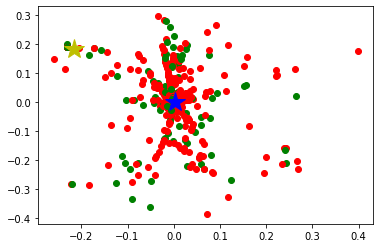

In [156]:
# print(ground_truth_cluster)

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,AffinityPropagation, SpectralClustering

# 读取数据
data = np.squeeze(np.array(grads_Loss_HL), axis = 1)
# 聚类数量
k = 2
# 训练模型
model_kmeans = KMeans(n_clusters=k)
model_kmeans.fit(data)
# 分类中心点坐标
centers = model_kmeans.cluster_centers_
# 预测结果
result = model_kmeans.predict(data)
ground_truth_cluster = np.zeros([len(result)], dtype=np.int32)
ground_truth_cluster[wrong_index]=1

# 用不同的颜色绘制数据点
mark = ['or', 'og']
for i, d in enumerate(data):
    plt.plot(d[0], d[1], mark[ground_truth_cluster[i]])
# 画出各个分类的中心点
mark = ['*b', '*y']
for i, center in enumerate(centers):
    plt.plot(center[0], center[1], mark[i], markersize=20)

In [157]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import svm
# 加载数据集
X = data  # 样本
y = ground_truth_cluster  # 类别
# 划分数据集
X_trainer, X_tester, Y_trainer, Y_tester = model_selection.train_test_split(data, ground_truth_cluster, test_size=0.3)
# 分类器
# kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
clf = svm.SVC(kernel="linear", probability=True)   # 参数kernel为线性核函数
clf.fit(X_trainer, Y_trainer)  # 训练分类器
print("Support Vector：\n", clf.n_support_)  # 每一类中属于支持向量的点数目
# print("Predict：\n", clf.predict(X_test))  # 对测试集的预测结果
score = clf.score(X_tester, Y_tester)  # 模型得分
print("Score：", score)

Support Vector：
 [225 204]
Score： 0.73


In [159]:
SVM_Gini_act = []
for data1 in data:
    SVM_Gini_act.append(  clf.predict_proba(data1.reshape(1, -1))[0][0]  )

indexs = np.argsort(SVM_Gini_act)
indexs = indexs[::-1]
# print(indexs)
APFD,wrong_number,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print("APFD: ", APFD, wrong_number)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print("RAUC: ", RAUC)


100% |########################################################################|


APFD:  0.6348333333333334 285
RAUC:  0.7393162393162394


In [177]:
input_shape_feature = 32
# from tensorflow.keras import regularizers
model_feature = Sequential()
model_feature.add(Dense(input_shape=(input_shape_feature), units=input_shape_feature, activation='relu'))
model_feature.add(Dense(units=128, 
#                         kernel_regularizer=regularizers.l2(0.1),
#                         activity_regularizer=regularizers.l1(),
                        activation='relu'))
model_feature.add(Dense(units=32, activation='relu'))
model_feature.add(Dense(units=1, activation='sigmoid'))
model_feature.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# model training
model_feature.fit(X_trainer, Y_trainer, epochs=5, batch_size=8)

# MODEL_PATH = "/public/liujiawei/huawei/ZHB/ADF-master/models/"
# model.save(MODEL_PATH+"fmnist_FC4_bad.h5")

# del model

In [179]:
MLP_Gini_act = []
for data1 in data:
#     MLP_Gini_act.append(  model_feature.predict(np.reshape(data1, (1,-1)))[0][0]  )
    MLP_Gini_act.append(  model_feature.predict(np.reshape(data1, (1,-1)))[0][0]  )

indexs = np.argsort(MLP_Gini_act)
# indexs = indexs[::-1]
# print(indexs)
APFD,wrong_number,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print("APFD: ", APFD, wrong_number)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print("RAUC: ", RAUC)

In [150]:
model_feature.predict(np.reshape(data1, (1,-1)))[0][0]

0.30898452

In [146]:
Y_trainer

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,

In [137]:
Gini_act =[]
pbar = ProgressBar()
for i in pbar(range(len(grads_CE))):
#     x_act = np.sum(np.abs(grads_CE[i]))
    x_act =[np.sum(np.abs(grads_CE[i])),
            np.sum(np.abs(grads_CE2[i])),
#             np.sum(np.abs(grads_CE_min[i])),
#             np.sum(np.abs(grads_RCE[i])),
#             np.sum(np.abs(grads_CE_ave[i])),
            np.sum(np.abs(grads_pre1[i])),
            np.sum(np.abs(grads_pre2[i])),
#             np.sum(np.abs(grads_pre_min[i]))
           ]
#     print(i,':',x_act)
    Gini_act.append(x_act)

In [138]:
Gini_act = np.array(Gini_act)
indexs = np.argsort(Gini_act[:,0]*Gini_act[:,0])
indexs = indexs[::-1]
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print('APFD:', APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_test, 
                predicted_confidence=np.array(predicted_confidence))
print('RAUC:', RAUC)

In [132]:
np.shape(grads_CE)

(300,)

In [119]:
def get_gradients(img_input, model, top_pred_idx):
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
#         print(np.shape(images))
#         print(np.shape(preds))
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 720,378
Trainable params: 720,378
Non-trainable params: 0
_________________________________________________________________


In [19]:
# # use one layer's activation
# get_activations = BE.function(inputs=model.inputs[0], outputs=model.layers[-1].output[:,:])
# Gini_act = []
# pbar = ProgressBar()
# for x_tmp in pbar(X_test):    
#     # 使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     att1 = np.dot(np.transpose(x_act), x_act)
#     att_weight = np.sum(att1, axis = 1).reshape(np.shape(x_act))
#     x_act_ = softmax(x_act*att_weight)
#     Gini_tmp = 1-np.sum(x_act_*x_act_)
#     Gini_tmp = -np.sum(x_act_*np.log2(x_act_))
#     Gini_act.append(Gini_tmp)
    
#     # 未使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     Gini_tmp = 1-np.sum(x_act*x_act)
# #     Gini_tmp = -np.sum(x_act*np.log2(x_act))
#     Gini_act.append(Gini_tmp)

# # use all layers' activation
# pbar = ProgressBar()
# get_activations1 = BE.function(inputs=model.inputs[0], outputs=model.layers[-1].output[:,:])
# get_activations2 = BE.function(inputs=model.inputs[0], outputs=model.layers[-2].output[:,:])
# get_activations3 = BE.function(inputs=model.inputs[0], outputs=model.layers[-3].output[:,:])
# Gini_act = []
# for x_tmp in pbar(X_test):
#     x_act1 = softmax(get_activations1(x_tmp.reshape([-1,28*28])))
#     x_act2 = softmax(get_activations2(x_tmp.reshape([-1,28*28])))
#     x_act3 = softmax(get_activations3(x_tmp.reshape([-1,28*28])))
# #     Gini_tmp = 1-np.sum(x_act3*x_act3)
# #     Gini_tmp = 1-(np.sum(x_act1*x_act1)+np.sum(x_act2*x_act2)+np.sum(x_act3*x_act3))/3
#     Gini_tmp = -np.sum(x_act3*np.log2(x_act3))
# #     Gini_tmp = (-np.sum(x_act1*np.log2(x_act1))-np.sum(x_act2*np.log2(x_act2))-np.sum(x_act3*np.log2(x_act3)))/3
#     Gini_act.append(Gini_tmp)
    
# indexs = np.argsort(Gini_act)
# indexs = indexs[::-1]
# o_i = 0
# pbar = ProgressBar()
# for i in pbar(range(0, (index1))):
#     x_tmp = X_test[indexs[i]].reshape([-1,28*28])
#     y_tmp = Y_test[indexs[i]]
#     per_tmp = model.predict(x_tmp)
#     if np.argmax(y_tmp)!=np.argmax(per_tmp):
#         o_i = o_i+i
# APFD = 1-o_i/(index1*(index1-index2))+1/(2*index1)
# print(APFD)

100% |########################################################################|
100% |########################################################################|


APFD: 0.7498684210526315
RAUC: 0.8690330477356181


In [ ]:
APFD 指标基于基尼系数
 使用所有层
0.9357219241773963 使用倒数第三层
0.946923104434907 使用倒数第二层
0.921514556509299 使用倒数第一层，即最后一层（DeepGini）


APFD 指标基于信息熵
0.9608580114449213 使用所有层
0.9608580114449213 使用倒数第三层
0.9326023962804005 使用倒数第二层
0.9212451001430615 使用倒数第一层，即最后一层